In [21]:
import os
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from xgboost import XGBClassifier
from datetime import datetime


In [22]:
import torch
torch.cuda.empty_cache()
#torch.cuda.is_available()
device = torch.device("cuda")
my_tensor = torch.tensor([1, 2, 3], device=device)
torch.cuda.max_memory_allocated()

1024

In [23]:
X_train = pd.read_csv('./data_enc/encoded_train.csv')
X_valid = pd.read_csv('./data_enc/encoded_valid.csv')

In [24]:
y_train= pd.read_csv('./data_enc/y_train.csv')
y_valid= pd.read_csv('./data_enc/y_valid.csv')

In [25]:
X_train

,Office ID,Process Type,Import Type,Import Use,Payment Type,Mode of Transport,Declarant ID,Importer ID,Seller ID,Courier ID,HS6 Code,Country of Departure,Country of Origin,Tax Rate,Tax Type,Country of Origin Indicator,Net Mass,Item Price
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1.799250e-06,5.283441e-05
1,2,1,1,1,1,2,2,2,2,1,2,2,2,2,2,2,1.891212e-04,5.333071e-05
2,3,1,1,1,1,2,3,3,3,1,3,2,2,3,3,3,3.448563e-07,7.597590e-07
3,2,1,1,1,2,2,4,4,4,1,4,3,3,1,4,2,1.535693e-04,2.097236e-04
4,3,1,1,1,1,1,5,5,5,1,5,3,3,4,2,3,3.998334e-04,9.033619e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100842,2,1,11,1,3,2,468,436,2563,7,208,4,2,1,4,2,3.665140e-08,2.076449e-08
100843,2,1,1,1,1,1,67,6989,3629,1,1099,2,2,9,3,3,2.019159e-06,5.453042e-07
100844,21,1,1,1,1,3,511,7459,3805,52,2489,2,2,6,3,2,3.573511e-04,1.683411e-02
100845,3,1,1,1,1,1,116,954,7974,1,12,2,2,1,4,3,4.231570e-07,9.807922e-05


In [26]:
y_train

,Fraud
0,0
1,0
2,0
3,0
4,0
...,...
100842,0
100843,0
100844,0
100845,0


In [27]:
from imblearn.over_sampling import RandomOverSampler

In [28]:

over_sampler = RandomOverSampler(random_state = 11)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)

In [29]:
print("Before oversampling:")
print(y_train.value_counts())
print("\nAfter oversampling:")
print(y_train_over.value_counts())

Before oversampling:
Fraud
0        73097
1        27750
Name: count, dtype: int64

After oversampling:
Fraud
0        73097
1        73097
Name: count, dtype: int64


In [30]:

y_train_over = np.array(y_train_over).ravel()
y_valid = np.array(y_valid).ravel()

In [31]:
xgb_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5994130001745845, max_delta_step=0, max_depth=7,
              min_child_weight=2,
              n_estimators=1500, n_jobs=20, num_parallel_tree=2, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=0, objective=  'binary:logistic', eval_metric='logloss')


In [32]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [33]:
from sklearn.metrics import confusion_matrix,precision_score,accuracy_score,recall_score,f1_score,roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average ='macro')
    recall = recall_score(y_test, pred, average ='macro')
    f1 = f1_score(y_test, pred, average ='macro')
    
    print("confusion\n", confusion)
    print("Accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f}, F1:{3:.4f}\n".format(accuracy, precision, recall, f1))
  

In [34]:
def get_model_train_eval(model, ftr_train = None, ftr_test = None, tgt_train = None, tgt_test = None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)
    

In [ ]:
from sklearn.model_selection import GridSearchCV
import joblib
from xgboost import plot_importance, XGBRFClassifier

param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [2000, 2500, 3000],
    'n_jobs': [20,25,30],
    'num_parallel_tree': [1,2,3]
     

}

grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_over, y_train_over)

print("Best Hyperparameters:", grid_search.best_params_)
best_xgb_model = grid_search.best_estimator_

best_xgb_model.fit(X_train_over, y_train_over)

joblib.dump(best_xgb_model, 'best_xgb_model.pkl')

def print_evaluation_metrics(y_true, y_pred):
    confusion = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    
    print("Confusion Matrix:\n", confusion)
    print("Accuracy: {0:.4f}, Precision: {1:.4f}, Recall: {2:.4f}, F1-score: {3:.4f}".format(accuracy, precision, recall, f1))

# Load the final model
loaded_model = joblib.load('best_xgb_model.pkl')

# Evaluate the final model on the validation set
pred_test = loaded_model.predict(X_valid)
print_evaluation_metrics(y_valid, pred_test)

# Plot feature importance
plot_importance(loaded_model, max_num_features=20)




Cross-validation Accuracy: 0.9192 (+/- 0.0031)

 Time taken: 0 hours 11 minutes and 46.84 seconds.
Confusion Matrix:
 [[15433   409]
 [  145  4072]]
Accuracy: 0.9724, Precision: 0.9497, Recall: 0.9699, F1-score: 0.9593


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

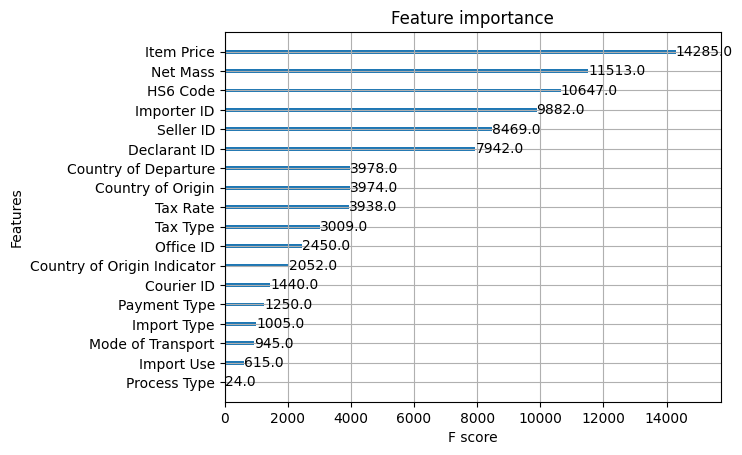

In [35]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np
import joblib
%matplotlib inline
from xgboost import plot_importance, XGBRFClassifier

#Best Hyperparameters:{'max_depth': 8, 'n_estimators': 2500, 'n_jobs': 20, 'num_parallel_tree': 2}

# Define XGBoost classifier

xgb_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                          colsample_bynode=1, colsample_bytree=0.6, gamma=1,
                          importance_type='gain', interaction_constraints='',
                          learning_rate=0.5994130001745845, max_delta_step=0, max_depth=8,
                          min_child_weight=3,
                          n_estimators=2500, n_jobs=20, num_parallel_tree=2, random_state=0,
                          reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
                          tree_method='exact', validate_parameters=1, verbosity=0,
                          objective='binary:logistic', eval_metric='logloss')

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

from sklearn.metrics import make_scorer, confusion_matrix, precision_score, accuracy_score, recall_score, f1_score, roc_auc_score


def print_evaluation_metrics(y_true, y_pred):
    confusion = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    
    print("Confusion Matrix:\n", confusion)
    print("Accuracy: {0:.4f}, Precision: {1:.4f}, Recall: {2:.4f}, F1-score: {3:.4f}".format(accuracy, precision, recall, f1))

def train_and_evaluate_with_cv(model, X, y, cv=5):
    start_time = timer(None)
    
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    cv_results = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    print("Cross-validation Accuracy: %0.4f (+/- %0.4f)" % (cv_results.mean(), cv_results.std() * 2))
    
    timer(start_time)


train_and_evaluate_with_cv(xgb_model, X_train_over, y_train_over)

xgb_model.fit(X_train_over, y_train_over)


joblib.dump(xgb_model, 'fraud_detection.pkl')

pred_test = xgb_model.predict(X_valid)

print_evaluation_metrics(y_valid, pred_test)

loaded_model = joblib.load('fraud_detection.pkl')

plot_importance(loaded_model, max_num_features=20)

In [32]:
import pickle
file_name = "./model/xgb_reg_eng.pkl"
os.makedirs('./model/', exist_ok = True)


pickle.dump(xgb_model, open(file_name, "wb"))

In [5]:
import streamlit as st
import numpy as np
import pandas as pd
import joblib
from xgboost import plot_importance

X_test = pd.read_csv('./data_enc/encoded_test.csv')
y_test = pd.read_csv('./data_enc/y_test.csv')



model="./model/xgb_reg_eng.pkl"
loaded_model = joblib.load(model)


def make_prediction(X_test):
    prediction = loaded_model.predict(X_test)
    return prediction


def plot_feature_importance():
    plot_importance(loaded_model, max_num_features=20)


def main():
    st.title('Model Evaluation and Visualization')

    st.sidebar.header('User Input')
    st.header('Feature Importance')
    plot_feature_importance()

if __name__ == '__main__':
    main()
